In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma, kv
from numpy import matlib

import torch
import mgplvm as mgp
import pickle
import time
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression, Ridge
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d
plt.rcParams['font.size'] = 20
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
np.random.seed(0)
torch.manual_seed(0)
device = mgp.utils.get_device() # use GPU if available, otherwise CPU
print(device)

import random
random.seed(0)

from scipy.linalg import cholesky
import scipy

loading
cuda


In [2]:
def squared_exponential_kernel(r, l):
    """
    Squared exponential kernel function
    """
    return np.exp(-(r**2)/(2*l**2))

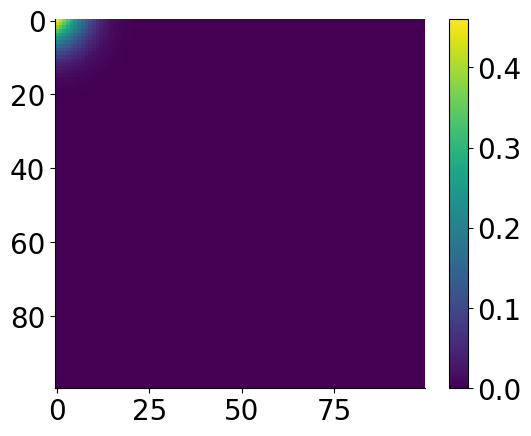

In [31]:
l = 0.2
start = 0
stop = 20
dt = 0.02
x_axis = np.linspace(start, stop, int((stop-start)/dt))
K = squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l)
# plt.imshow(K)
# plt.show()

K_1_2 = np.linalg.cholesky(K + np.eye(len(x_axis))*1e-6)
# plt.imshow(K_1_2)
# plt.show()

K_1_2_approx = ((2/np.pi)**(1/4))*np.sqrt(dt/l)*squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l/np.sqrt(2))
# plt.imshow(K_1_2_approx)
# plt.show()

K_1_2_approx2 = (2/np.pi)**(1/4)*(l)**(-3/2)*squared_exponential_kernel(x_axis[:, None] - x_axis[None, :], l/np.sqrt(2))
# plt.imshow(K_1_2_approx2)
# plt.show()

# plt.imshow(np.abs(K - K_1_2.dot(K_1_2.T) - np.eye(len(x_axis))*1e-6))
# plt.colorbar()
# plt.show()

plt.imshow(np.abs(K - K_1_2_approx.dot(K_1_2_approx))[:100, :100])
plt.colorbar()
plt.show()
# print(np.sum(np.abs(K - K_1_2_approx.dot(K_1_2_approx)), axis=0))

# print(np.abs(K - K_1_2_approx2.dot(K_1_2_approx2)))

